# Construct Kaplan-Meier Curve and Survival Model from Published Life Table

In meta-analyses and systematic reviews of rare diseases, individual patient data are often not publicly available. When only a life table is reported, we can still reconstruct a plausible Kaplan–Meier function and survival curve by making transparent assumptions.

This notebook provides a step-by-step guide to reconstructing a Kaplan–Meier curve from a published life table. Once the Kaplan–Meier function is derived, we can better understand the overall survival pattern and estimate key time-to-event metrics, such as the median time to symptom onset in this use case.

## Import necesssary modules

In [ ]:
import lifelines # Survival analysis library
from lifelines import KaplanMeierFitter # Fit Kaplan-Meier model

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Tabularize life-table

The life table was extracted from a research paper describing the onset of interstitial lung disease (ILD) in a cohort. ILD is a symptom in which lung tissue becomes damaged and cannot fully expand or fill with air.

In [ ]:
# Create lifetable DataFrame from given data
data = {
    "year": [0, 1, 2, 3, 4, 5],
    "symptoms_free": [745, 592, 382, 262, 171, 97]
}

df = pd.DataFrame(data)

print(df)

   year  symptoms_free
0     0            745
1     1            592
2     2            382
3     3            262
4     4            171
5     5             97


The life table reports the number of patients who remained free of the symptom of interest over a follow-up period of up to five years. 

It provides the number of patients surviving without ILD from year 1 through year 5, as well as the number at risk at year 0, corresponding to the index date of the retrospective cohort.

## Compute event per interval

Next, we need to back-calculate the number of patients who developed the symptom during each time interval.

We assume that no patients were censored and that each individual has a binary status, either with or without the symptom. Under this assumption, the number of events in a given year can be calculated as the difference between the number of symptom-free patients in the previous year and the number of symptom-free patients in the current year.

For example, the number of events in year 1 equals the number of symptom-free patients at year 0 minus the number of symptom-free patients at year 1.

In [40]:
# Compute events per interval (from symptoms_free counts)
df["events"] = df["symptoms_free"].shift(1) - df["symptoms_free"]
df.loc[0, "events"] = 0  # no event at time 0
print(df)

   year  symptoms_free  events
0     0            745     0.0
1     1            592   153.0
2     2            382   210.0
3     3            262   120.0
4     4            171    91.0
5     5             97    74.0


The *events* column in the table represents the back-calculated number of patients who developed ILD during each time interval.

## Creat expanded individual-patient data

Next, we recreate an individual-level dataset that includes each patient’s observed time and symptom-free status, with one row per individual. In this dataset, a value of 1 indicates that the patient developed the symptom, while 0 indicates that the patient remained symptom-free.

In [41]:
# Create expanded individual-level dataset for Kaplan-Meier fitting
records = []
for _, row in df.iterrows():
    year = row["year"]
    events = int(row["events"])
    # event cases
    for i in range(events):
        records.append({"time": year, "event": 1})
for i in range(int(df.iloc[-1]["symptoms_free"])):
    records.append({"time": 5, "event": 0})

df_long = pd.DataFrame(records)


We then verify that the reconstructed dataset contains the correct number of patients at risk (n = 745).

In [37]:
print(f'The total rows in df_long: {df_long.shape[0]}')

The total rows in df_long: 745


The total number of rows matches the full number of patients at risk.

We further inspect the distribution of patients who remained symptom-free versus those who developed symptoms within each time interval.

In [22]:
df_long.value_counts()

time  event
2.0   1        210
1.0   1        153
3.0   1        120
5.0   0         97
4.0   1         91
5.0   1         74
Name: count, dtype: int64

The table is now ready for fitting the Kaplan–Meier model.

## Fit Kaplan-Meier survival function

We will fit a Kaplan–Meier function using the reconstructed dataset, applying the KaplanMeierFitter function from the lifelines module.

In [38]:
# Fit Kaplan-Meier model
km = KaplanMeierFitter()
km.fit(durations=df_long["time"], event_observed=df_long["event"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 745 total observations, 97 right-censored observations>

## Visualize Kaplan-Meier function

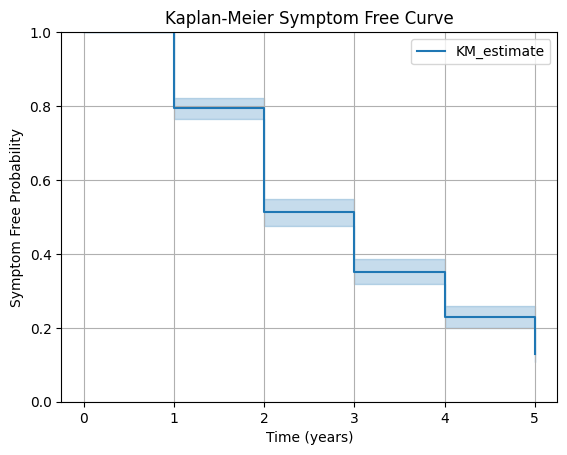

In [42]:
# Plot survival function
km.plot_survival_function()

plt.title("Kaplan-Meier Symptom Free Curve")
plt.xlabel("Time (years)")
plt.ylabel("Symptom Free Probability")
plt.ylim(0, 1)
plt.grid()
plt.show()

The survival curve illustrates the Kaplan–Meier function from the index year through the end of the follow-up period in the retrospective cohort study.

Each downward step within a time interval reflects the assumption that patients in that interval have a uniform probability of remaining symptom-free.

## Estimate median time to symptom onset

We are able to obtain the median time to symptom onset directly from the Kaplan–Meier function. This is useful for understanding the overall pattern of symptom development in the cohort.

In [ ]:
# Print median survival time
print("Median Symptom Free Time:", km.median_survival_time_)

Median Symptom free Time: 3.0
